In [50]:
import numpy as np
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

### For saving and restoring session data

# Load the Data

## Metadata

In [3]:
root_path = 'C:/Users/Owner/Documents/Sac State/CORD-19-research-challenge'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389


## JSON Files

In [4]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

33375

### Helper Functions

In [5]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

In [6]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load data into dataframe

In [7]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])

    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 33375
Processing index: 3337 of 33375
Processing index: 6674 of 33375
Processing index: 10011 of 33375
Processing index: 13348 of 33375
Processing index: 16685 of 33375
Processing index: 20022 of 33375
Processing index: 23359 of 33375
Processing index: 26696 of 33375
Processing index: 30033 of 33375
Processing index: 33370 of 33375


,paper_id,abstract,body_text,authors,title,journal,abstract_summary
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir..."
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.
3,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...
4,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,A Combined Evidence Approach to Prioritize<br...,NaN,Nipah Virus (NiV) came into limelight recentl...


In [8]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30197 entries, 0 to 30196
Data columns (total 7 columns):
paper_id            30197 non-null object
abstract            30197 non-null object
body_text           30197 non-null object
authors             29646 non-null object
title               30162 non-null object
journal             29077 non-null object
abstract_summary    30197 non-null object
dtypes: object(7)
memory usage: 1.6+ MB


# Preprocessing

## Add column word counts

In [10]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))

## Drop NA and String Formatting

In [11]:
df_covid.dropna(inplace=True)

In [12]:
df_covid['body_text'] = df_covid['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

In [13]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: lower_case(x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: lower_case(x))

In [14]:
len(df_covid)

28527

## Clustering

### Vectorizing (TF-IDF)

In [34]:
stopWords = open('C:/Users/Owner/Documents/Sac State/stopwords.txt').read().splitlines()
len(stopWords)

1112

In [35]:
vectorizer = TfidfVectorizer(max_features=2**14, stop_words = stopWords)
X = vectorizer.fit_transform(df_covid['body_text'].values)

In [36]:
X.shape

(28527, 16384)

### PCA (scales well) & K-Means

In [37]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(X.toarray())

In [38]:
k = 20
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(pca_result)

In [39]:
len(y_pred)

28527

#### Visualizing Our Clusters

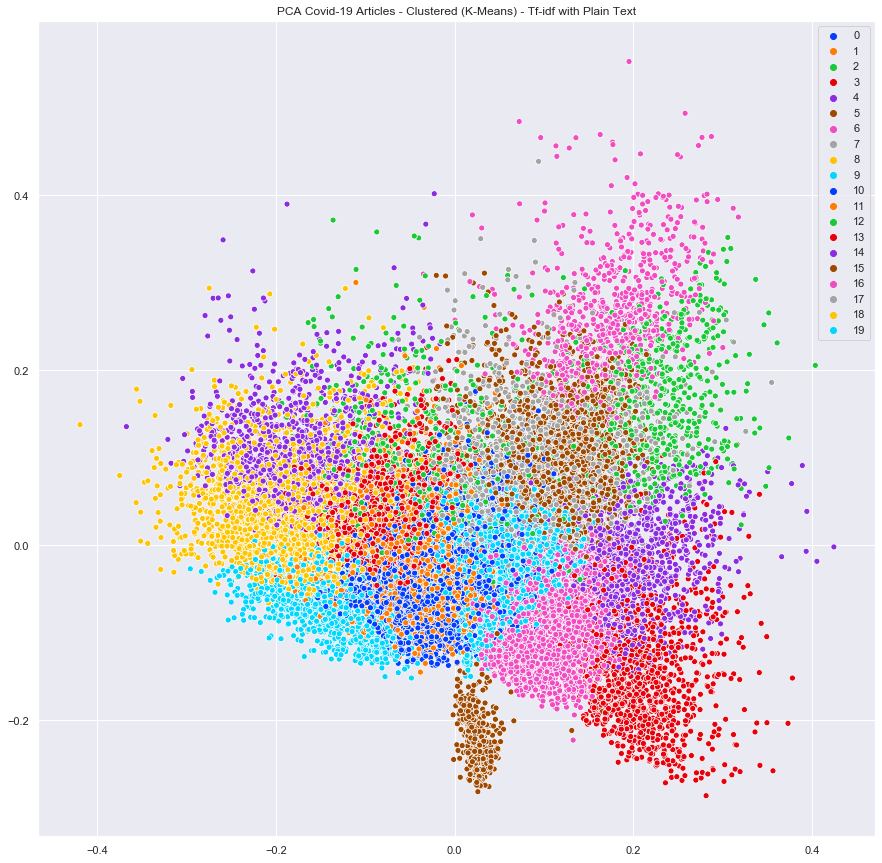

In [40]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(pca_result[:,0], pca_result[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("PCA Covid-19 Articles - Clustered (K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/pca_covid19_label_TFID.png")
plt.show()

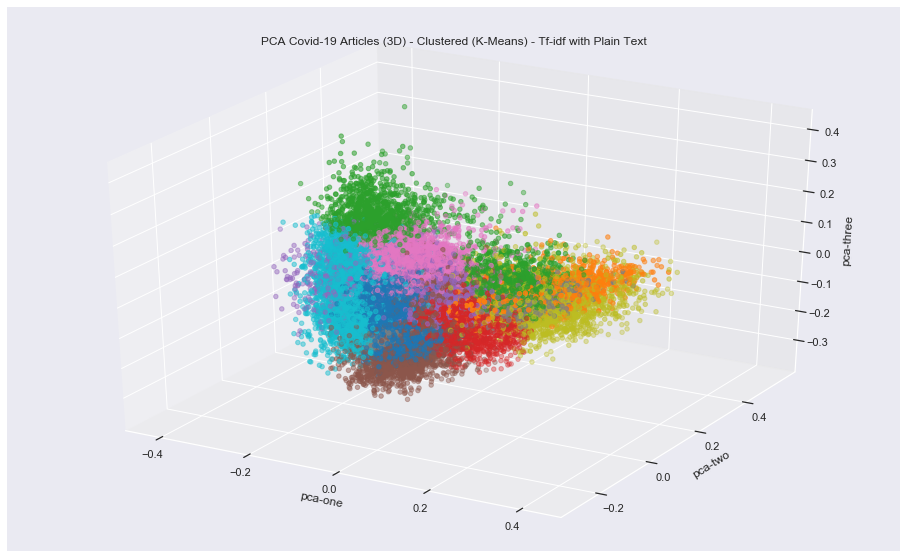

In [41]:
%matplotlib inline
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y_pred, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.title("PCA Covid-19 Articles (3D) - Clustered (K-Means) - Tf-idf with Plain Text")
# plt.savefig("plots/pca_covid19_label_TFID_3d.png")
plt.show()

## Sampling

In [42]:
classDict = {}
for i in range(k):
    classDict[i] = []

In [44]:
for index, ele in enumerate(y_pred):
    classDict[ele].append(df_covid.iloc[index])

In [66]:
clusterPops = [len(classDict[i]) for i in range(len(classDict))]
mySample = []
for index, ele in enumerate(classDict):
    mySample.append(classDict[ele][0:(clusterPops[index] // 2)])
mySamp = [item for elem in mySample for item in elem]
len(mySamp)

14258